In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import os
import cv2
from tensorflow.keras import layers, Sequential, datasets, Model
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    optimizers,
)


2024-03-13 12:14:12.894929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 12:14:12.895029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 12:14:13.020364: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir_path = r"/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
def load_images(folder_path, img_size = (128, 128)):
    X = []
    limit = 50000
    for img_name in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img_array = cv2.imread(img_path)
        img_array = cv2.resize(img_array, img_size)
        img_array = img_array[:,:,::-1]
        X.append(img_array / 255.0)
        if len(X) >= limit:
            break
    return np.array(X)

img_size = 64
X_train = load_images(dir_path, (img_size, img_size))
X_train.shape

 25%|██▍       | 49999/202599 [03:54<11:57, 212.82it/s]


(50000, 64, 64, 3)

In [3]:
fixed_noise = tf.random.normal((60, 128))

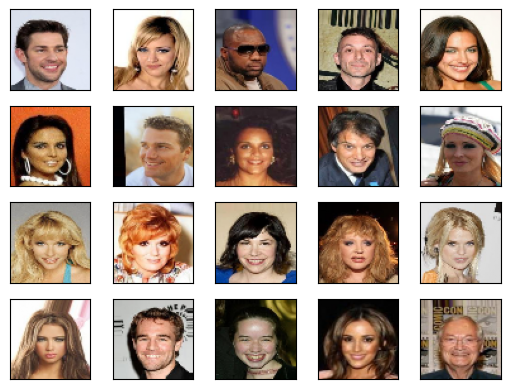

In [4]:
def show_images(images):
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()
show_images(X_train)

In [5]:
discriminator_input = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)

In [6]:
generator_input = layers.Input(shape=(128,))
x = layers.Reshape((1, 1, 128))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    3, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)

In [7]:
class GAN(Model):
    def __init__(self, Generator, Discriminator):
        super().__init__()
        self.latent_dim = 128
        self.generator = Generator
        self.discriminator = Discriminator
        # print(self.generator.model.summary())
    def compile(self, gen_optimizer, disc_optimizer, criterion):
        super().compile()
        self.generator_optimizer = gen_optimizer
        self.discriminator_optimizer = disc_optimizer
        self.cross_entropy = criterion

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss


    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def train_step(self, images):
        
        noise = tf.random.normal([images.shape[0], self.latent_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"Generator Loss": gen_loss, "Discriminator Loss": disc_loss}

In [8]:
model = GAN(generator, discriminator)
model.compile(gen_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              disc_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              criterion = tf.keras.losses.BinaryCrossentropy(True))

In [9]:
model.fit(X_train, epochs = 100, batch_size = 100)

Epoch 1/100
  3/500 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - Discriminator Loss: 1.1350 - Generator Loss: 1.3801

I0000 00:00:1710332326.119927      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710332326.145222      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - Discriminator Loss: 0.3330 - Generator Loss: 2.4256 - loss: 0.0000e+00
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - Discriminator Loss: 0.5400 - Generator Loss: 1.9357 - loss: 0.0000e+00
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - Discriminator Loss: 0.6752 - Generator Loss: 1.6720 - loss: 0.0000e+00
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - Discriminator Loss: 0.6485 - Generator Loss: 1.7745 - loss: 0.0000e+00
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - Discriminator Loss: 0.6351 - Generator Loss: 1.9352 - loss: 0.0000e+00
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - Discriminator Loss: 0.6449 - Generator Loss: 1.9354 - loss: 0.0000e+00
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - Discriminator Loss: 0.6018 - Generator Loss: 2.0135 - loss: 0.0000e+00
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - Discriminator Loss: 0.5380 - Generator Loss: 2.1379 - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


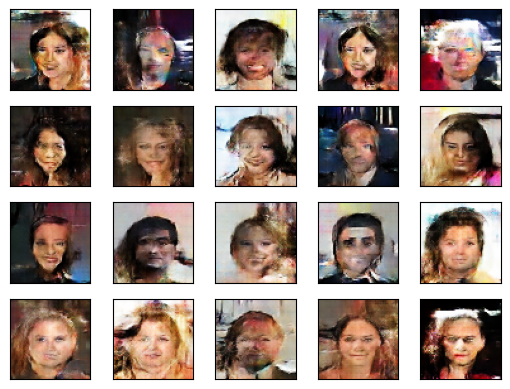

In [10]:
y_pred = model.generator.predict(fixed_noise)
show_images(y_pred)